# JL Refresh

In [65]:
import sys
from joblib import Parallel, delayed
sys.path.append(r"Z:\comlib") 

from utilities import azure_datalake, holiday
from stlf.utilities import holiday_class
adl = azure_datalake()

from math import sqrt
import pandas as pd
import numpy as np
import pickle
import yaml

# Common Usage

In [11]:
[sqrt(i**2) for i in range(10)]

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [18]:
Parallel(n_jobs=2)(delayed(sqrt)(i**2) for i in range(10))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [19]:
# second part is actually a generator , only generator is allowed in JobLib
(delayed(sqrt)(i**2) for i in range(10))

<generator object <genexpr> at 0x0000019D3B316E60>

In [20]:
# in list form
[delayed(sqrt)(i**2) for i in range(10)]

[(<function math.sqrt>, (0,), {}),
 (<function math.sqrt>, (1,), {}),
 (<function math.sqrt>, (4,), {}),
 (<function math.sqrt>, (9,), {}),
 (<function math.sqrt>, (16,), {}),
 (<function math.sqrt>, (25,), {}),
 (<function math.sqrt>, (36,), {}),
 (<function math.sqrt>, (49,), {}),
 (<function math.sqrt>, (64,), {}),
 (<function math.sqrt>, (81,), {})]

# Use Case

Concat many files into one csv

In [29]:
# function to run in parallel 
def read_pickle(adl, file):
    return pickle.load(adl.open(file))

## Concat Many Files into One DF

In [25]:
all_files  = adl.listdir("userzone/innovation/bdt/stlf/actual_temp")

In [27]:
pkl_files = [file for file in all_files if file.split('.')[-1] == 'pkl']

In [47]:
# same as above, feed it into a generator, no need to use tuple args, unless below is a list to check
args = (delayed(read_pickle)(adl, file) for file in pkl_files)

In [48]:
data = Parallel(n_jobs=64, backend="threading", verbose=1)(args)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    5.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 2207 out of 2207 | elapsed:   15.9s finished


In [55]:
len(data)

2207

In [56]:
data_combined = pd.concat(data)

# Nested Multiprocessing

Get all csv files across 4 different paths

In [111]:
def get_file_date(f_name, rpath):
    ts = f_name.replace(rpath + "/", "").replace(".pkl", "")
    return datetime.strptime(ts, "%Y%m%d").date()

def get_data(adl, rpath):
    
    pickle_files = [file for file in adl.listdir(rpath) if file.endswith(".pkl")]
        
    args = (delayed(read_pickle)(adl, file)  for file in pickle_files)
    data = Parallel(n_jobs=64, backend="threading", verbose=1)(args)
    data = pd.concat(data)
        
    return data

In [112]:
def load_config():
    with open(r"K:\Projects\short_term_load_forecast\stlf_deployment\v_2_0\src\op_config.yml") as fp:
        config = yaml.load(fp, Loader=yaml.SafeLoader)
        fp.close()
        return config
    
def daterange(date1 , date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [113]:
config=load_config()

rpaths=config["data"]

In [114]:
rpaths

{'source_status': 'userzone/innovation/bdt/stlf/status.json',
 'actual_demand': 'userzone/innovation/bdt/stlf/demand',
 'actual_temp': 'userzone/innovation/bdt/stlf/actual_temp',
 'forecast_temp': 'userzone/innovation/bdt/stlf/forecast_temp',
 'public_holiday': 'userzone/innovation/bdt/stlf/public_holiday_v2',
 'forecast_demand': 'userzone/innovation/bdt/stlf/forecast_result/v_2_0_0',
 'model_img': {'rpath': 'userzone/innovation/bdt/stlf/model/v_2_0_0',
  'lpath': '../model'}}

In [118]:
paths_list = [ rpaths['actual_demand'], rpaths['actual_temp'], rpaths['forecast_temp'], rpaths['public_holiday']]

In [138]:
args_full = (delayed(get_data)(adl, p) for p in paths_list)

In [139]:
data_list = Parallel(n_jobs=len(paths_list), backend='loky')(args_full)

In [146]:
df_demand = data_list[0]

In [143]:
output_checking = pd.read_csv(r'K:\Projects\short_term_load_forecast\stlf_deployment\v_2_0\src\output_checking_2020-01-20.csv')

In [145]:
output_checking['Timestamp'] = pd.to_datetime(output_checking['Timestamp'])

In [147]:
compare = df_demand.merge(output_checking, how='inner', on='Timestamp')

In [149]:
def mean_absolute_percentage_error(df): 
    y_true = np.array(df['Demand_x'])
    y_pred = np.array(df['Demand_y'])
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [150]:
mean_absolute_percentage_error(compare)

2.551626965399655

In [154]:
%matplotlib inline

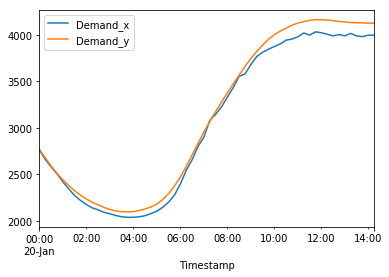

In [155]:
compare.set_index('Timestamp').plot()